In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numpy.fft import rfft, rfftfreq

In [9]:
empty = pd.read_csv("empty_fs1kHz.csv", header=None )



In [11]:
LP = pd.read_csv("LP_fs1000Hz_fc40Hz.csv", header=None)

In [12]:
LP

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
0,0.00355,-0.085368,-0.022325,-0.019602,-0.017549,-0.01362,-0.007634,0.000266,0.009909,0.020896,...,0.020896,0.009909,0.000266,-0.007634,-0.01362,-0.017549,-0.019602,-0.022325,-0.085368,0.00355


In [15]:
# Question 1:
 #What is the size of the EMPTY_fs1kHz signal? a. The data are sampled at 1000 times per second (1kHz). What is the duration of the signal, based on the SIZE and the SAMPLING RATE?

empty.shape
sampling_rate = 1000 #Hz
duration = empty.shape[0] / sampling_rate
duration #seconds

10.0

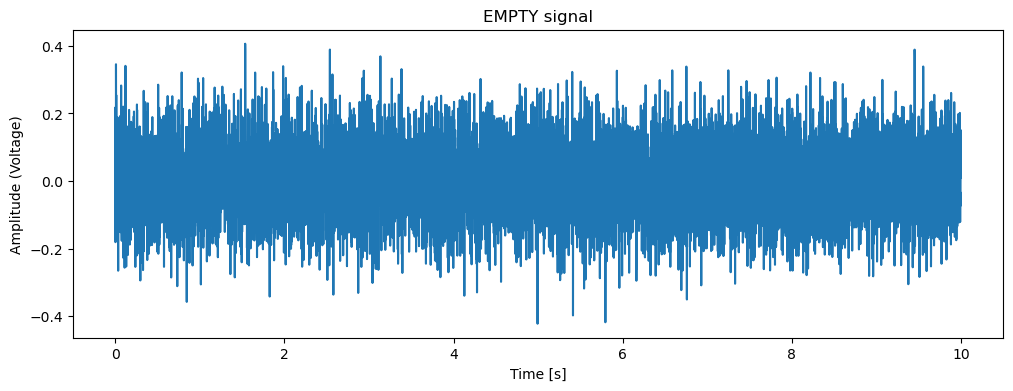

In [20]:
# Question 2:
 #Plot the EMPTY signal. What do you observe? (Hint: use matplotlib.pyplot.plot function)

# Sampling rate
fs = 1000  # Hz

# Time vector (same length as signal)
t = np.arange(len(empty)) / fs

# Full signal plot
plt.figure(figsize=(12,4))
plt.plot(t, empty)
plt.title("EMPTY signal")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude (Voltage)")
plt.show()


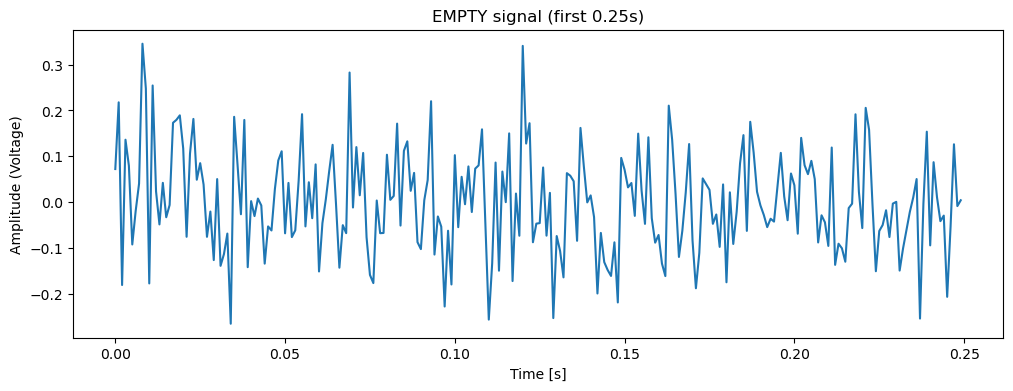

In [21]:
# Question 3:
 #Plot the first 0.25 seconds of the EMPTY signal. What do you observe?

# number of samples in 0.25s
N = int(0.25 * fs)

plt.figure(figsize=(12,4))
plt.plot(t[:N], empty[:N])
plt.title("EMPTY signal (first 0.25s)")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude (Voltage)")
plt.show()

In [ ]:
# Question 4: 

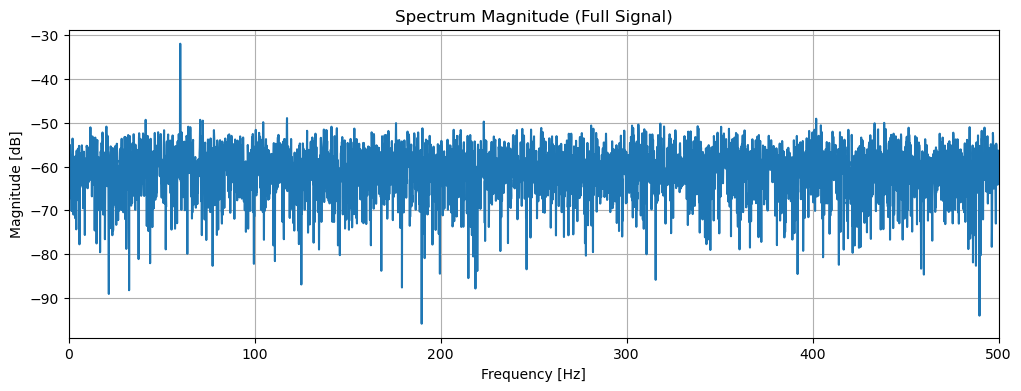

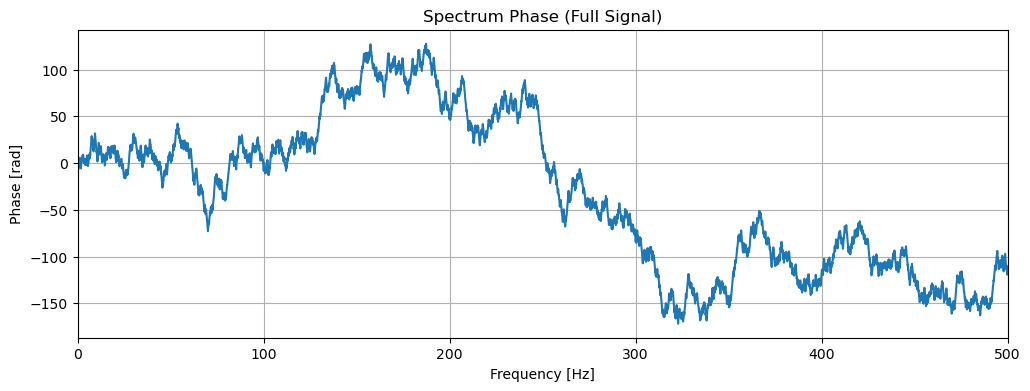

In [26]:

# --- Load signal (no header) ---
fs = 1000  # Hz
x = pd.read_csv("empty_fs1kHz.csv", header=None).squeeze("columns").to_numpy()
N = len(x)

# --- Optional: apply a window to reduce leakage ---
window = np.hanning(N)
xw = x * window
# Coherent gain for Hann window (to keep amplitude roughly correct)
cg = window.mean()

# --- FFT on windowed signal (one-sided) ---
X = rfft(xw)
freqs = rfftfreq(N, d=1/fs)

# --- Magnitude (dB) ---
# Normalize by (N * cg) so a pure tone's amplitude is on the right scale
mag = np.abs(X) / (N * cg)
mag_db = 20 * np.log10(np.maximum(mag, 1e-12))  # avoid log(0)

# --- Phase (radians), unwrapped ---
phase = np.unwrap(np.angle(X))

# ----- Plot: Magnitude -----
plt.figure(figsize=(12,4))
plt.plot(freqs, mag_db)
plt.title("Spectrum Magnitude (Full Signal)")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Magnitude [dB]")
plt.grid(True)
plt.xlim(0, fs/2)  # one-sided spectrum up to Nyquist (500 Hz)
plt.show()

# ----- Plot: Phase -----
plt.figure(figsize=(12,4))
plt.plot(freqs, phase)
plt.title("Spectrum Phase (Full Signal)")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Phase [rad]")
plt.grid(True)
plt.xlim(0, fs/2)
plt.show()


In [35]:
# Question 5 and 6 : Reduce sampling rate  

def analyze_downsample(x, fs, factor, zoom_time=0.25):
    # --- Downsample ---
    x_ds = x[::factor]
    fs_ds = fs // factor
    N_ds = len(x_ds)
    t_ds = np.arange(N_ds) / fs_ds

    # --- Time domain plot (zoom in to first zoom_time seconds) ---
    N_zoom = int(zoom_time * fs_ds)
    plt.figure(figsize=(10,4))
    plt.plot(t_ds[:N_zoom], x_ds[:N_zoom])
    plt.title(f"Downsampled signal (fs = {fs_ds} Hz, first {zoom_time} s)")
    plt.xlabel("Time [s]")
    plt.ylabel("Voltage [V]")
    plt.grid(True)
    plt.show()

    # --- Frequency domain plot (magnitude only) ---
    X = rfft(x_ds)
    freqs = rfftfreq(N_ds, 1/fs_ds)
    mag = np.abs(X) / N_ds
    mag_db = 20 * np.log10(np.maximum(mag, 1e-12))  # avoid log(0)

    plt.figure(figsize=(10,4))
    plt.plot(freqs, mag_db)
    plt.title(f"Spectrum Magnitude (fs = {fs_ds} Hz)")
    plt.xlabel("Frequency [Hz]")
    plt.ylabel("Magnitude [dB]")
    plt.grid(True)
    plt.xlim(0, fs_ds/2)  # Nyquist
    plt.show()

    return x_ds, fs_ds


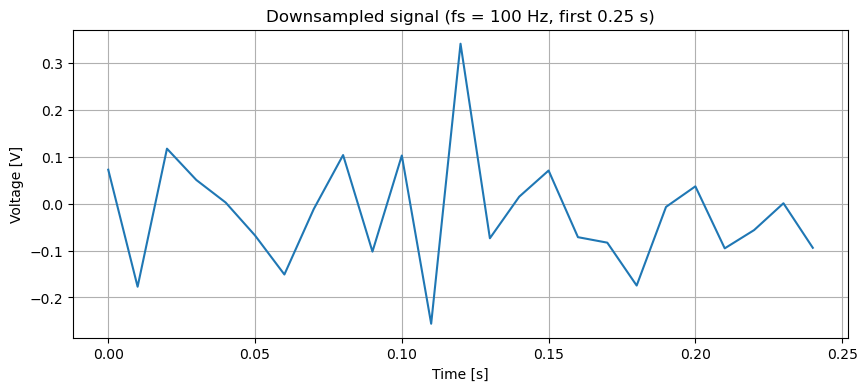

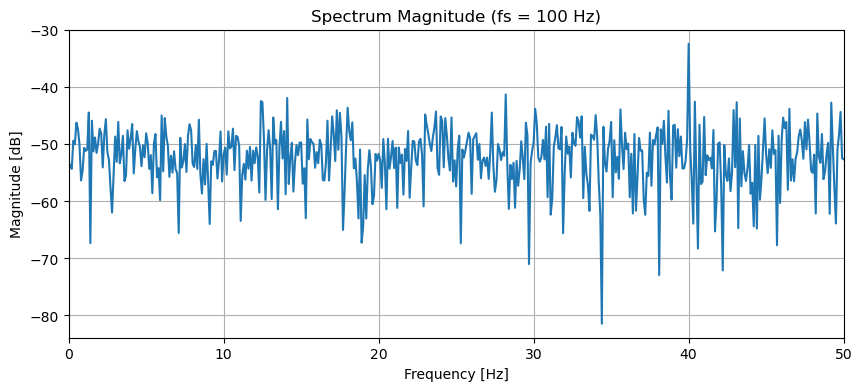

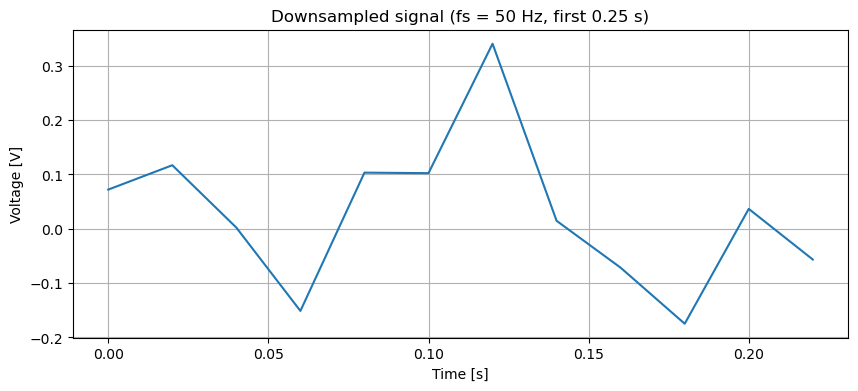

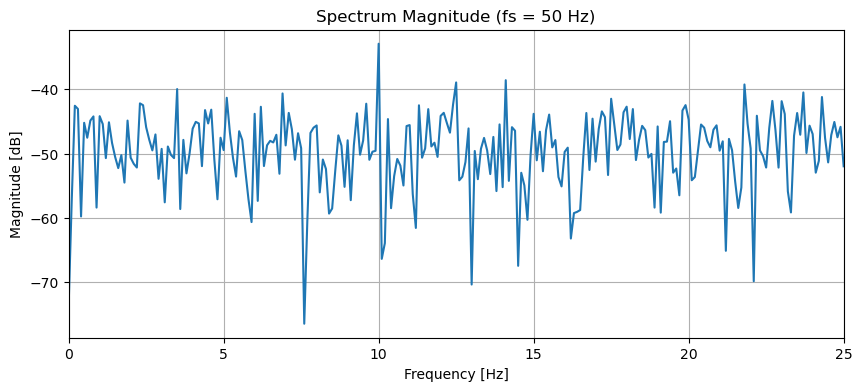

In [36]:
# Downsample to 100 Hz
x100, fs100 = analyze_downsample(x, fs, factor=10)

# Downsample to 50 Hz
x50, fs50 = analyze_downsample(x, fs, factor=20)


In [43]:
np.convolve(empty, h, mode="same")


ValueError: object too deep for desired array

In [44]:
import numpy as np
import pandas as pd
from scipy.signal import lfilter  # safer for FIR filtering

fs = 1000  # Hz

def load_1d_numeric_csv(path):
    # Auto-detect delimiter, read as strings, then coerce to numeric
    s = pd.read_csv(path, header=None, sep=None, engine="python")
    # If it's multi-column, collapse to a single Series (e.g., first non-empty col)
    if s.shape[1] > 1:
        # Keep only numeric-looking entries across columns
        s = s.apply(pd.to_numeric, errors="coerce")
        # If multiple columns, pick the one with most non-NaN values
        col = s.notna().sum().idxmax()
        s = s[col]
    else:
        s = pd.to_numeric(s.iloc[:,0], errors="coerce")
    # Drop NaNs and ensure 1-D float array
    a = s.dropna().to_numpy(dtype=float).ravel()
    return a

# Load as clean 1-D float arrays
x = load_1d_numeric_csv("empty_fs1kHz.csv")              # signal
h = load_1d_numeric_csv("LP_fs1000Hz_fc40Hz.csv")        # FIR low-pass coefficients

print("x shape/dtype:", x.shape, x.dtype)
print("h shape/dtype:", h.shape, h.dtype)

# Option A: convolution (equivalent to FIR filtering)
y = np.convolve(x, h, mode="same")

# Option B (recommended for FIR): direct filtering
# y = lfilter(h, 1.0, x)

print("y shape/dtype:", y.shape, y.dtype)


ParserError: Expected 4 fields in line 27, saw 5